In [0]:
import os
import cv2
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = os.path.join("/content/drive/My Drive/Face_Data")
!ls "/content/drive/My Drive/Face_Data"

Train_dir = base_dir + '/Train/'
Test_dir = base_dir + '/Test/'
Valid_dir = base_dir + "/Validation/"

nb_train_samples = sum([len(files) for _, _, files in os.walk(Train_dir)])
nb_validation_samples = sum([len(files) for _, _, files in os.walk(Valid_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(Test_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Test  Train  Validation
 - # of trained samples:  788 
 - # of validation samples:  181 
 - # of test samples:  171 
 - total # of samples:  1140 
 - train ratio: 69.12 
 - validation ratio: 15.88 
 - test ratio: 15.0


# **Loading Data**
## **Splitting the data is already done in here**
### Split the Data into Train, Validation, Test sets.

Few changes have done as project concerend. 
Since the original data was too large, it took all the resources in the RAM. I was not able to test how many convolutional layers to test them out. 

So, here is the thing that I have done.

1.   First resize to 600 x 300
2.   Crop only for the actor's face by 90 x 140.
3.   Clean the data where there was some Harry picture in Hermione Folder, and so on



In [0]:
class_names = ['Dumbledore', 'Hagrid', 'Harry', 'Hermione', 'Malfoy', 'Ron']

class_names_label = {class_name : i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (90, 140)

In [0]:
def load_data():
  datasets = [Train_dir, Valid_dir, Test_dir]
  output = []
  
  for dataset in datasets:
    Images = []
    Labels = []

    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      curr_label = class_names_label[folder]

      for file in os.listdir(os.path.join(dataset, folder)):
        img_path = os.path.join(os.path.join(dataset, folder), file)

        curr_img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        #gray_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        #Whether or not there is bad file, print that image_path
        try:
          curr_img = cv2.resize(curr_img, IMAGE_SIZE)
        except cv2.error as e:
          print(img_path, 'Invalid Frame!')
        cv2.waitKey()  

        Images.append(curr_img)
        Labels.append(curr_label)

    Images = np.array(Images)
    Labels = np.array(Labels)
    output.append((Images, Labels))
  return output  

In [0]:
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = load_data()

Loading /content/drive/My Drive/Face_Data/Train/
Loading /content/drive/My Drive/Face_Data/Validation/
Loading /content/drive/My Drive/Face_Data/Test/


In [0]:
print ("Number of Training Examples: " + str(train_labels.shape[0]))
print ("Number of Validation Examples : " + str(valid_images.shape[0]))
print ("Number of Testing Examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[0:]))

print("Size of Test image : " + str(test_images.shape[0:]))

Number of Training Examples: 788
Number of Validation Examples : 181
Number of Testing Examples: 171
Each image is of size: (788, 140, 90)
Size of Test image : (171, 140, 90)


## **Data Analysis**

### Training Data
Training data of movie character is almost distributed same, about 16 percent to 17 percents.  It is possible to add more if more cropped face is used.

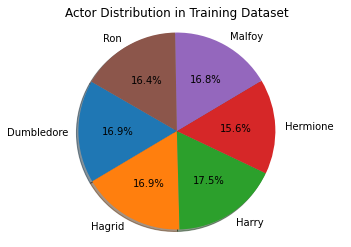

In [0]:
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Actor Distribution in Training Dataset')
plt.show()

# **Data Processing**

## **Step : Normalize the Images**

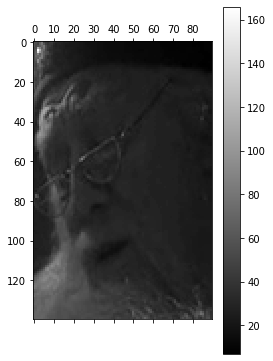

In [0]:
plt.matshow( train_images[35], cmap='gray')
plt.colorbar()
plt.show()

In [0]:
print(train_labels[35])

0


In [0]:
x_train = train_images.reshape((788, 140, 90, 1))
x_valid = valid_images.reshape((181, 140, 90, 1))
x_test = test_images.reshape((test_images.shape[0], 140, 90, 1))

train_img = x_train / 255.0 
valid_img = x_valid / 255.0
test_img = x_test / 255.0

In [0]:
print(train_labels.shape)
print(train_labels[0])

(788,)
0


### **One Hot-Encoding**

In [0]:
y_train = tf.keras.utils.to_categorical(train_labels)
y_valid = tf.keras.utils.to_categorical(valid_labels)
y_test = tf.keras.utils.to_categorical(test_labels)
print(y_train.shape)
print(y_train[0])

(788, 6)
[1. 0. 0. 0. 0. 0.]


# **Build Convolutional Neural Network with Drop-out**

### Component : Three Convolutional and MaxPool layers.
1. Convolutional 2D Layer was 64 filters with 3 by 3
2. Second Layer was BatchNormalization layer.

In [0]:
train_img[0, :, :, :].shape

(140, 90, 1)

In [0]:
model = Sequential()
model.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model.add(BatchNormalization())
model.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add( Flatten() )
model.add( Dense(128, activation = 'relu' ) )
model.add( Dense(6, activation = 'sigmoid' ) )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

## **Step : Compile the model**

In [0]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

In [0]:
history = model.fit(train_img, y_train, validation_data= (valid_img, y_valid), epochs=500, 
                    batch_size= 32, callbacks= [callback_a, callback_b])

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.5254
Epoch 00001: val_loss improved from inf to 0.59188, saving model to my_best_model.hdf5
25/25 [==============================] - 1s 27ms/step - loss: 0.4090 - accuracy: 0.5254 - val_loss: 0.5919 - val_accuracy: 0.3204
Epoch 2/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1627 - accuracy: 0.8289
Epoch 00002: val_loss improved from 0.59188 to 0.55679, saving model to my_best_model.hdf5
25/25 [==============================] - 0s 15ms/step - loss: 0.1575 - accuracy: 0.8350 - val_loss: 0.5568 - val_accuracy: 0.3204
Epoch 3/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0757 - accuracy: 0.9390
Epoch 00003: val_loss improved from 0.55679 to 0.50265, saving model to my_best_model.hdf5
25/25 [==============================] - 0s 15ms/step - loss: 0.0766 - accuracy: 0.9365 - val_loss: 0.5027 - val_accuracy: 0.4420
Epoch 4/500
21/25 [========================>.....] - ETA

In [0]:
print(history.params)

{'verbose': 1, 'epochs': 500, 'steps': 25}


### Show the learning Curve.

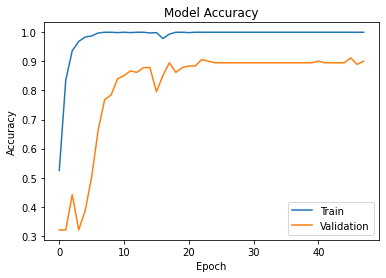

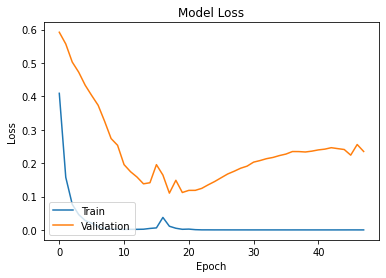

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

## **Step: Evalue the model on the validation set.**

In [0]:
validation_loss, validation_acc = model.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc )

6/6 [==============================] - 0s 4ms/step - loss: 0.2349 - accuracy: 0.9006
validation_acc: 0.90055251121521


In [0]:
predictions = model.predict( valid_img )

In [0]:
predictions = np.argmax(predictions, axis=1)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(valid_labels, predictions)
precision = precision_score(valid_labels, predictions, average='micro')
recall = recall_score(valid_labels, predictions, average='micro')
f1_score = f1_score(valid_labels, predictions, average='micro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1-score: %.2f" % (f1_score* 100.0))

Accuracy: 90.06%
Precision: 90.06%
Recall: 90.06%
F1-score: 90.06


## Visualizing a random image

In [0]:
def display_random(class_names, images, labels):
  images = images.reshape((test_img.shape[0], 140, 90))
  index = np. random.randint(images.shape[0])
  plt.figure()
  plt.imshow(images[index])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('Image #{} : '.format(index) + class_names[labels[index]])
  plt.show()

## **Evaluating on the Test set**

In [0]:
test_loss, test_acc = model.evaluate(test_img, y_test)

6/6 [==============================] - 0s 9ms/step - loss: 0.4597 - accuracy: 0.7836


In [0]:
predictions_test = model.predict(test_img)
pred_label_test = np.argmax(predictions_test, axis=1)

print(pred_label_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 3 4 4 3 4
 4 3 3 5 4 4 1 4 5 4 5 3 4 4 4 4 2 0 2 3 5 5 2 5 2 2 5 5 1 2 5 2 3 2 2 5 3
 2 2 2 2 2 2 2 2 3 5 5 5 3 5 5 0 3 5 5 5 5 5 5 5 5 5 2 0 2 2 3 2 5 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 3 3 5 3 3 3 3 3 5 3 3 3 3 5 5 3 3 3 3]


In [0]:
print(test_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


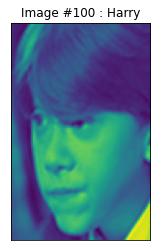

In [0]:
display_random(class_names, test_img, pred_label_test)

# **Test Result**

## **Confusion Matrix Result**
With evaluating the validation data for this model, does terrible job on the test data, but fairly good on Malfoy and Harry
it seems like it does poorly on Hagird, Hermione, Dumbledore, and Ron.

One possible resolution could be shuffle this right.

## **The Accuracy Report**
The accuracy on test data were 56 percent, which is not good. As observed, the loss is very high.

In [0]:
def show_mislabeled_images(class_names, test_images, test_labels, pred_labels):
  print(test_images.shape)
  test_images = test_images.reshape((test_images.shape[0], 140, 90))
  compare = (test_labels == pred_labels)
  mislabeled_index = np.where(compare == 0)
  mislabeled_images = test_images[mislabeled_index]
  mislabeled_labels = pred_labels[mislabeled_index]

  fig = plt.figure(figsize = (10,10))
  fig.suptitle("Misclassified Image in dataset")
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[mislabeled_labels[i]])
    
  plt.show()

(171, 140, 90, 1)


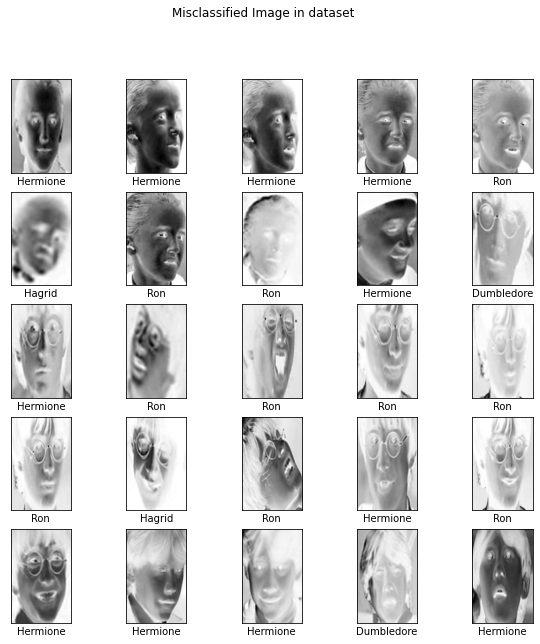

In [0]:
show_mislabeled_images(class_names, test_img, test_labels, pred_label_test)

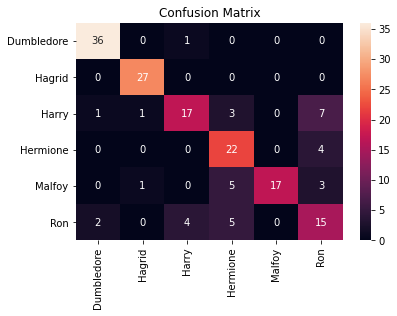

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, pred_label_test)
ax = plt.axes()
sns.heatmap(cm, annot=True,
            annot_kws={"size" : 10},
            xticklabels=class_names,
            yticklabels=class_names, ax = ax)
ax.set_title('Confusion Matrix')
plt.show()


# **Build another CNN Model**

In this step, we are going to increase the more CNN layers by think how many layers do I need to have. Some simple idea is to observe what would determine the facial component, which they are eyes, nose, mouth, and hair. Therefore it might require little bit more than 5 CNN Layers.

In [0]:
K.clear_session()
model = Sequential()
model.add( Conv2D(64, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model.add(BatchNormalization())
model.add( Conv2D(32, (3, 3), activation = 'relu' ) )
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model.add(BatchNormalization())
model.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(16, ( 3, 3 ), activation = 'relu' ) )
model.add(BatchNormalization())
model.add( Flatten() )
model.add( Dense(128, activation = 'relu' ) )
model.add( Dense(6, activation = 'sigmoid' ) )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 41, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 39, 32)        9

In [0]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_c = ModelCheckpoint(filepath = 'my_best_model.hdf6', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_d = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

In [0]:
history_1 = model.fit(train_img, y_train, validation_data= (valid_img, y_valid), epochs=600, 
                    batch_size= 10, callbacks= [callback_c, callback_d])

Epoch 1/600
79/79 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.7246
Epoch 00001: val_loss improved from inf to 0.69815, saving model to my_best_model.hdf6
79/79 [==============================] - 1s 13ms/step - loss: 0.2943 - accuracy: 0.7246 - val_loss: 0.6981 - val_accuracy: 0.1657
Epoch 2/600
78/79 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9295
Epoch 00002: val_loss did not improve from 0.69815
79/79 [==============================] - 1s 9ms/step - loss: 0.0878 - accuracy: 0.9302 - val_loss: 0.9902 - val_accuracy: 0.1657
Epoch 3/600
78/79 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9692
Epoch 00003: val_loss did not improve from 0.69815
79/79 [==============================] - 1s 9ms/step - loss: 0.0449 - accuracy: 0.9695 - val_loss: 0.9385 - val_accuracy: 0.3425
Epoch 4/600
78/79 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9846
Epoch 00004: val_loss did not improve from 

In [0]:
print(history_1.params)

{'verbose': 1, 'epochs': 600, 'steps': 79}


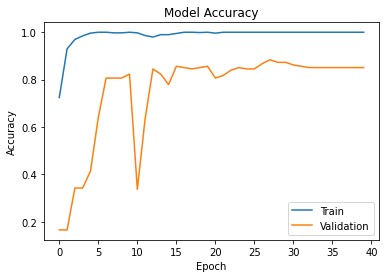

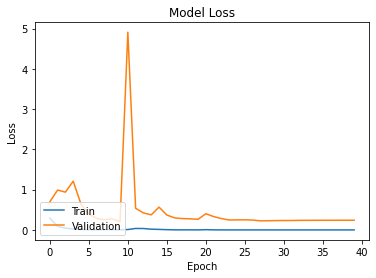

In [0]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_1, validation_acc_1 = model.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_1 )

6/6 [==============================] - 0s 16ms/step - loss: 0.2384 - accuracy: 0.8508
validation_acc: 0.8508287072181702


In [0]:
predictions_1 = model.predict( valid_img )

In [0]:
predictions_1 = np.argmax(predictions_1, axis=1)

In [0]:
accuracy_1 = accuracy_score(valid_labels, predictions_1)
precision_1 = precision_score(valid_labels, predictions_1, average='micro')
recall_1 = recall_score(valid_labels, predictions_1, average='micro')
#f1_score_1 = f1_score(valid_labels, predictions_1, average='micro')
print("Accuracy: %.2f%%" % (accuracy_1 * 100.0))
print("Precision: %.2f%%" % (precision_1 * 100.0))
print("Recall: %.2f%%" % (recall_1 * 100.0))
#print("F1-score: %.2f" % (f1_score_1* 100.0))

Accuracy: 85.08%
Precision: 85.08%
Recall: 85.08%


In [0]:
test_loss_1, test_acc_1 = model.evaluate(test_img, y_test, verbose=1)

6/6 [==============================] - 0s 13ms/step - loss: 0.3365 - accuracy: 0.8070


# **Test Result_1**

By having more CNN Layers result was poorier than the first result, which the validation accuracy was 92 %, but the accuracy on the test data was 39 %.

In [0]:
K.clear_session()
model = Sequential()
model.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model.add(BatchNormalization())
model.add( Conv2D(32, (3, 3), activation = 'relu' ) )
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add( Flatten() )
model.add( Dense(128, activation = 'relu' ) )
model.add( Dense(6, activation = 'sigmoid' ) )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 43, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 93568)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [0]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_e = ModelCheckpoint(filepath = 'my_best_model.hdf6', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_f = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

In [0]:
history_2 = model.fit(train_img, y_train, validation_data= (valid_img, y_valid), epochs=600, 
                    batch_size= 10, callbacks= [callback_e, callback_f])

Epoch 1/600
79/79 [==============================] - ETA: 0s - loss: 2.1432 - accuracy: 0.7259
Epoch 00001: val_loss improved from inf to 1.14185, saving model to my_best_model.hdf6
79/79 [==============================] - 1s 13ms/step - loss: 2.1432 - accuracy: 0.7259 - val_loss: 1.1418 - val_accuracy: 0.1713
Epoch 2/600
73/79 [==========================>...] - ETA: 0s - loss: 0.7065 - accuracy: 0.9123
Epoch 00002: val_loss did not improve from 1.14185
79/79 [==============================] - 1s 7ms/step - loss: 0.7071 - accuracy: 0.9112 - val_loss: 3.4761 - val_accuracy: 0.1657
Epoch 3/600
73/79 [==========================>...] - ETA: 0s - loss: 0.3346 - accuracy: 0.9616
Epoch 00003: val_loss did not improve from 1.14185
79/79 [==============================] - 1s 8ms/step - loss: 0.3408 - accuracy: 0.9607 - val_loss: 3.0168 - val_accuracy: 0.3094
Epoch 4/600
73/79 [==========================>...] - ETA: 0s - loss: 0.1469 - accuracy: 0.9822
Epoch 00004: val_loss did not improve from 

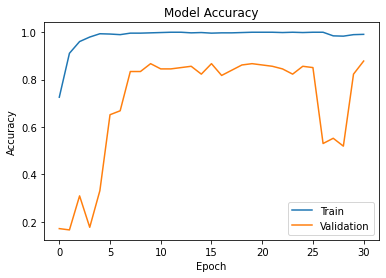

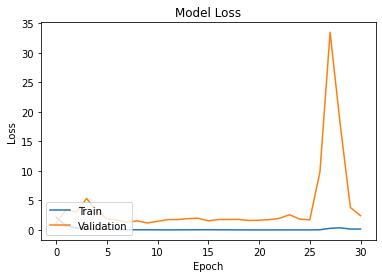

In [0]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_2, validation_acc_2 = model.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_2)

6/6 [==============================] - 0s 7ms/step - loss: 2.5658 - accuracy: 0.8785
validation_acc: 0.8784530162811279


In [0]:
predictions_2 = model.predict( valid_img )
predictions_2 = np.argmax(predictions_2, axis=1)

In [0]:
accuracy_2 = accuracy_score(valid_labels, predictions_2)
precision_2 = precision_score(valid_labels, predictions_2, average='micro')
recall_2 = recall_score(valid_labels, predictions_2, average='micro')
#f1_score_2 = f1_score(valid_labels, predictions_2, average='micro')
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))
print("Precision: %.2f%%" % (precision_2 * 100.0))
print("Recall: %.2f%%" % (recall_1 * 100.0))
#print("F1-score: %.2f" % (f1_score_1* 100.0))

Accuracy: 88.40%
Precision: 88.40%
Recall: 85.08%


In [0]:
test_loss_2, test_acc_2 = model.evaluate(test_img, y_test, verbose=1)

6/6 [==============================] - 0s 6ms/step - loss: 6.0907 - accuracy: 0.6316


In [0]:
predictions_test_2 = model.predict(test_img)
pred_label_test_2 = np.argmax(predictions_test_2, axis = 1)

(171, 140, 90, 1)


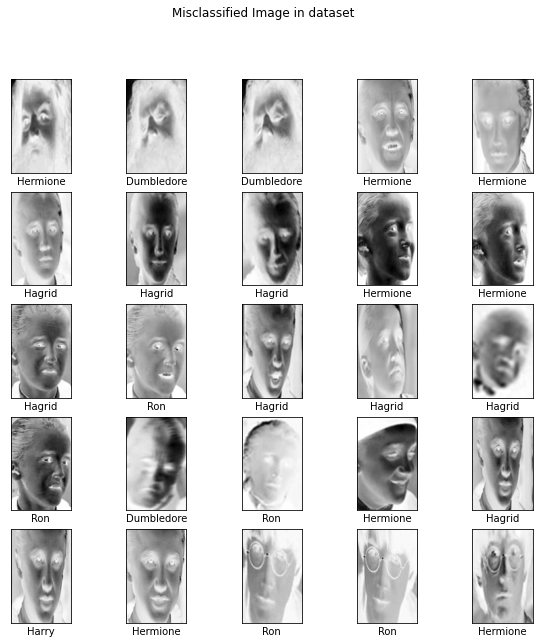

In [0]:
show_mislabeled_images(class_names, test_img, test_labels, pred_label_test_2)

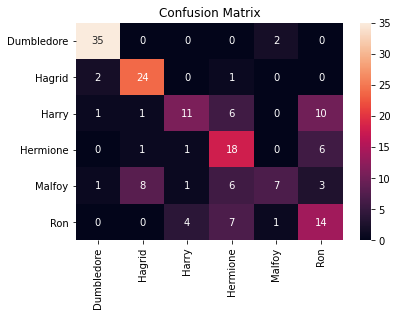

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, pred_label_test_2)
ax = plt.axes()
sns.heatmap(cm, annot=True,
            annot_kws={"size" : 10},
            xticklabels=class_names,
            yticklabels=class_names, ax = ax)
ax.set_title('Confusion Matrix')
plt.show()


#**Phase 4. Data Augmentation**


1.   With the best model obtained from the previous step, apply various techniques of data augmentation (Image generators) and study the improvement in accuracy

2.   Plot your learning curves and include them in your report



#**Batch size = 20, with 20 percents changing**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator = validation_datagen.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator = test_datagen.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_data_aug = Sequential()
model_data_aug.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug.add(BatchNormalization())
model_data_aug.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug.add(MaxPool2D(pool_size=(2,2)))
model_data_aug.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug.add(MaxPool2D(pool_size=(2,2)))
model_data_aug.add(Dropout(0.25))
model_data_aug.add( Flatten() )
model_data_aug.add( Dense(128, activation = 'relu' ) )
model_data_aug.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

In [0]:
model_data_aug.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_g = ModelCheckpoint(filepath = 'my_best_model.hdf7', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_h = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_aug = model_data_aug.fit_generator(train_generator, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_g, callback_h],
                                       validation_data=validation_genrator,
                                       validation_steps =valid_images.shape[0] / 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.5711
Epoch 00001: val_loss improved from inf to 0.54266, saving model to my_best_model.hdf7
100/100 [==============================] - 9s 94ms/step - loss: 0.3118 - accuracy: 0.5734 - val_loss: 0.5427 - val_accuracy: 0.1989
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2331 - accuracy: 0.7117
Epoch 00002: val_loss improved from 0.54266 to 0.48153, saving model to my_best_model.hdf7
100/100 [==============================] - 9s 88ms/step - loss: 0.2336 - accuracy: 0.7113 - val_loss: 0.4815 - val_accuracy: 0.3757
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.7480
Epoch 00003: val_loss improved from 0.48153 to 0.35008, saving model to my_best_model.hdf7
100/100 [==============================] - 9s 91ms/step - loss: 0.2051 - accuracy: 0.7480 - val_loss

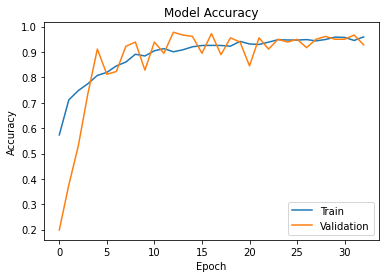

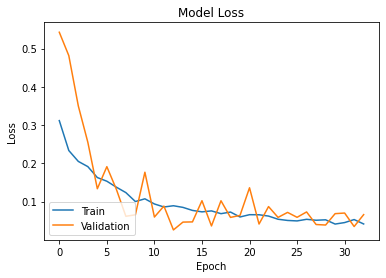

In [0]:
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_aug, validation_acc_aug = model_data_aug.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_aug)

6/6 [==============================] - 0s 5ms/step - loss: 0.0641 - accuracy: 0.9282
validation_acc: 0.9281768202781677


In [0]:
validation_loss_aug2, validation_acc_aug2 = model_data_aug.evaluate_generator(validation_genrator, steps=10)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [0]:
print('validation_acc:', validation_acc_aug2)

validation_acc: 0.9281768202781677


In [0]:
test_loss_aug, test_acc_aug = model_data_aug.evaluate_generator(test_generator, steps=30)

In [0]:
print('test_acc:', test_acc_aug)

validation_acc: 0.9239766001701355


In [0]:
predictions_aug = model.predict( valid_img )
predictions_aug = np.argmax(predictions_aug, axis=1)

In [0]:
test_loss_aug_r, test_acc_aug_r = model_data_aug.evaluate(test_img, y_test, verbose=1)
print(test_acc_aug_r)

6/6 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.9240
0.9239766001701355


#**Show Augmented Image for examples**

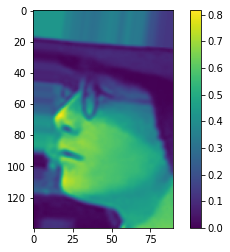

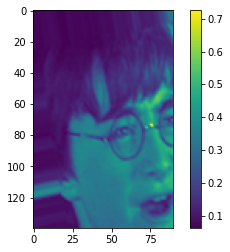

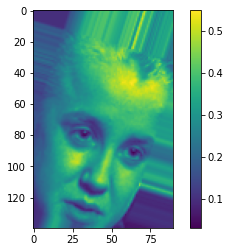

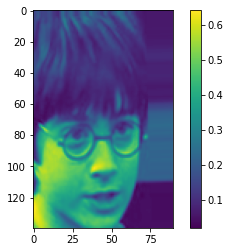

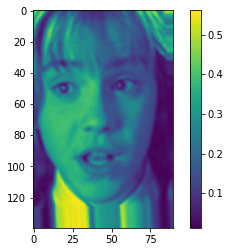

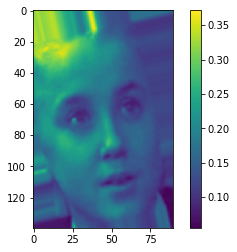

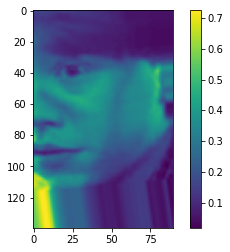

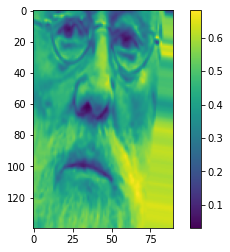

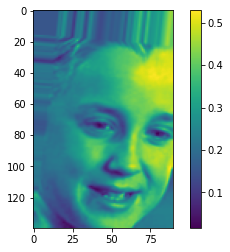

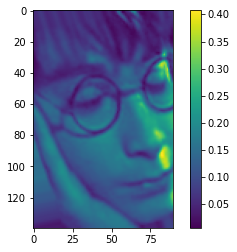

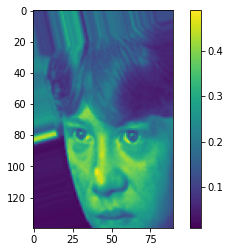

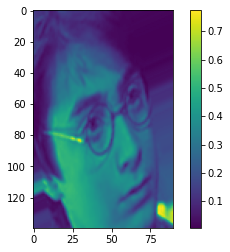

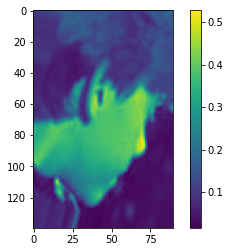

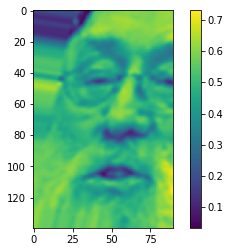

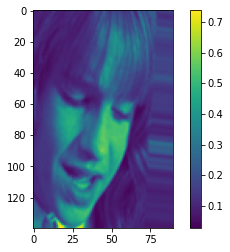

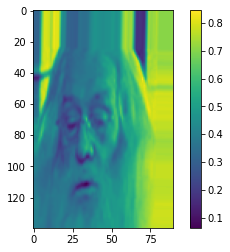

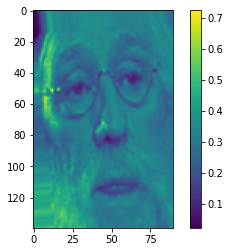

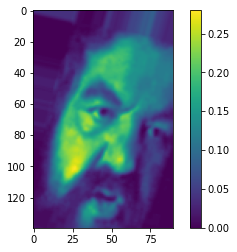

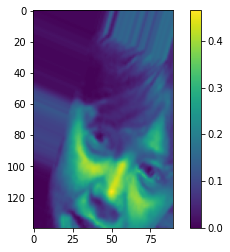

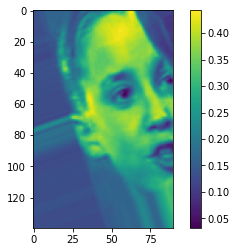

In [0]:
for my_batch in train_generator:
    # my_batch is a tuple with images and labels
    images = my_batch[0].reshape((20, 140, 90))
    labels = my_batch[1]
    for i in range(len(labels)):
        # Gives one image and its corresponding label
        plt.imshow(images[i])
        plt.colorbar()
        plt.show()
    break

#**Batch size = 50, with 20 percents changing**

In [0]:
train_datagen_1 = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_1 = ImageDataGenerator(rescale=1./255)
test_datagen_1 = ImageDataGenerator(rescale=1./255)

train_generator_1 = train_datagen.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_1 = validation_datagen.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_1 = test_datagen.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_data_aug_1 = Sequential()
model_data_aug_1.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug_1.add(BatchNormalization())
model_data_aug_1.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_1.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_1.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_1.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_1.add(Dropout(0.25))
model_data_aug_1.add( Flatten() )
model_data_aug_1.add( Dense(128, activation = 'relu' ) )
model_data_aug_1.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

In [0]:
model_data_aug_1.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_i = ModelCheckpoint(filepath = 'my_best_model.hdf8', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_j = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_aug_1 = model_data_aug_1.fit_generator(train_generator_1, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_g, callback_h],
                                       validation_data=validation_genrator_1,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.5834
Epoch 00001: val_loss did not improve from 0.02616
100/100 [==============================] - 15s 154ms/step - loss: 0.3192 - accuracy: 0.5834 - val_loss: 0.5027 - val_accuracy: 0.3315
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.7486
Epoch 00002: val_loss did not improve from 0.02616
100/100 [==============================] - 15s 154ms/step - loss: 0.2065 - accuracy: 0.7486 - val_loss: 0.4360 - val_accuracy: 0.3260
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.8024
Epoch 00003: val_loss did not improve from 0.02616
100/100 [==============================] - 16s 157ms/step - loss: 0.1711 - accuracy: 0.8024 - val_loss: 0.3650 - val_accuracy: 0.4751
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.8291
Epoch 00004: val_loss did not improve from 0.02616
100/10

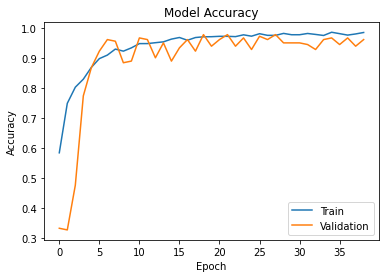

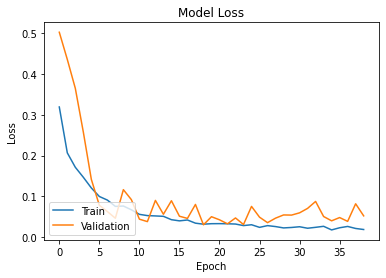

In [0]:
plt.plot(history_aug_1.history['accuracy'])
plt.plot(history_aug_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_aug_1.history['loss'])
plt.plot(history_aug_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_aug_3, validation_acc_aug_3 = model_data_aug_1.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_aug_3)

6/6 [==============================] - 0s 4ms/step - loss: 0.0489 - accuracy: 0.9613
validation_acc: 0.9613259434700012


In [0]:
validation_loss_aug3, validation_acc_aug3 = model_data_aug_1.evaluate_generator(validation_genrator_1, steps=10)
print(validation_acc_aug3)

0.9613259434700012


In [0]:
test_loss_aug_1, test_acc_aug_1 = model_data_aug_1.evaluate_generator(test_generator_1, steps=30)
print(test_acc_aug_1)

0.9122806787490845


In [0]:
test_loss_aug_r1, test_acc_aug_r1 = model_data_aug_1.evaluate(test_img, y_test, verbose=1)
print(test_acc_aug_r1)

6/6 [==============================] - 0s 4ms/step - loss: 0.0779 - accuracy: 0.9064
0.9064327478408813


#**30 % of changing Rotation... so on**

In [0]:
train_datagen_2 = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.3,
                               height_shift_range=0.3,
                               shear_range=0.3,
                               zoom_range=0.3,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_2 = ImageDataGenerator(rescale=1./255)
test_datagen_2 = ImageDataGenerator(rescale=1./255)

train_generator_2 = train_datagen.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_2 = validation_datagen.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_2 = test_datagen.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_data_aug_2 = Sequential()
model_data_aug_2.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug_2.add(BatchNormalization())
model_data_aug_2.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_2.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_2.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_2.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_2.add(Dropout(0.25))
model_data_aug_2.add( Flatten() )
model_data_aug_2.add( Dense(128, activation = 'relu' ) )
model_data_aug_2.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

In [0]:
model_data_aug_2.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_k = ModelCheckpoint(filepath = 'my_best_model.hdf9', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_l = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_aug_2 = model_data_aug_2.fit_generator(train_generator_1, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_k, callback_l],
                                       validation_data=validation_genrator_2,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.5921
Epoch 00001: val_loss improved from inf to 0.49958, saving model to my_best_model.hdf9
100/100 [==============================] - 15s 154ms/step - loss: 0.3315 - accuracy: 0.5921 - val_loss: 0.4996 - val_accuracy: 0.2873
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.7299
Epoch 00002: val_loss improved from 0.49958 to 0.47941, saving model to my_best_model.hdf9
100/100 [==============================] - 15s 153ms/step - loss: 0.2214 - accuracy: 0.7299 - val_loss: 0.4794 - val_accuracy: 0.2762
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.8036
Epoch 00003: val_loss improved from 0.47941 to 0.40168, saving model to my_best_model.hdf9
100/100 [==============================] - 15s 154ms/step - loss: 0.1726 - accuracy: 0.8036 - val_loss: 0.4017 - val_accuracy: 0.3370
Epoch 4/100
100/100 [=================

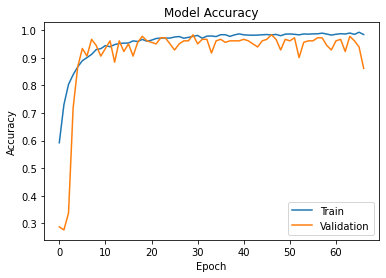

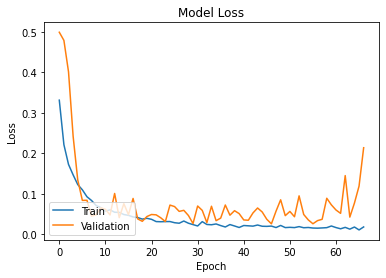

In [0]:
plt.plot(history_aug_2.history['accuracy'])
plt.plot(history_aug_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_aug_2.history['loss'])
plt.plot(history_aug_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_aug_4, validation_acc_aug_4 = model_data_aug_2.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_aug_4)

6/6 [==============================] - 0s 5ms/step - loss: 0.2029 - accuracy: 0.8619
validation_acc: 0.8618784546852112


In [0]:
validation_loss_aug4, validation_acc_aug4 = model_data_aug_2.evaluate_generator(validation_genrator_2, steps=10)
print(validation_acc_aug4)

0.8618784546852112


In [0]:
test_loss_aug_2, test_acc_aug_2 = model_data_aug_2.evaluate_generator(test_generator_2, steps=30)
print(test_acc_aug_2)

0.7485380172729492


In [0]:
test_loss_aug_r1, test_acc_aug_r1 = model_data_aug_2.evaluate(test_img, y_test, verbose=1)
print(test_acc_aug_r1)

6/6 [==============================] - 0s 4ms/step - loss: 0.3931 - accuracy: 0.7544
0.7543859481811523


#**40 % of changing Rotation... so on**

In [0]:
train_datagen_3 = ImageDataGenerator(rotation_range=40,
                               width_shift_range=0.4,
                               height_shift_range=0.4,
                               shear_range=0.4,
                               zoom_range=0.4,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_3 = ImageDataGenerator(rescale=1./255)
test_datagen_3 = ImageDataGenerator(rescale=1./255)

train_generator_3 = train_datagen.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_3 = validation_datagen.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_3 = test_datagen.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_data_aug_3 = Sequential()
model_data_aug_3.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug_3.add(BatchNormalization())
model_data_aug_3.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_3.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_3.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_3.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_3.add(Dropout(0.25))
model_data_aug_3.add( Flatten() )
model_data_aug_3.add( Dense(128, activation = 'relu' ) )
model_data_aug_3.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

In [0]:
model_data_aug_3.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_m = ModelCheckpoint(filepath = 'my_best_model.hdf10', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_n = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_aug_3 = model_data_aug_3.fit_generator(train_generator_3, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_m, callback_n],
                                       validation_data=validation_genrator_3,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.6100
Epoch 00001: val_loss improved from inf to 0.63637, saving model to my_best_model.hdf10
100/100 [==============================] - 15s 154ms/step - loss: 0.2926 - accuracy: 0.6100 - val_loss: 0.6364 - val_accuracy: 0.1713
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.7640
Epoch 00002: val_loss improved from 0.63637 to 0.57933, saving model to my_best_model.hdf10
100/100 [==============================] - 15s 153ms/step - loss: 0.1975 - accuracy: 0.7640 - val_loss: 0.5793 - val_accuracy: 0.2762
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.8342
Epoch 00003: val_loss improved from 0.57933 to 0.42801, saving model to my_best_model.hdf10
100/100 [==============================] - 15s 153ms/step - loss: 0.1508 - accuracy: 0.8342 - val_loss: 0.4280 - val_accuracy: 0.4309
Epoch 4/100
100/100 [==============

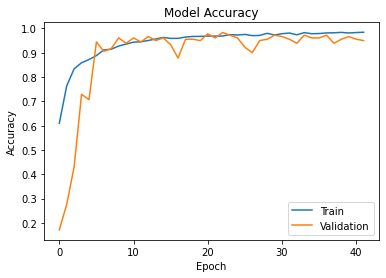

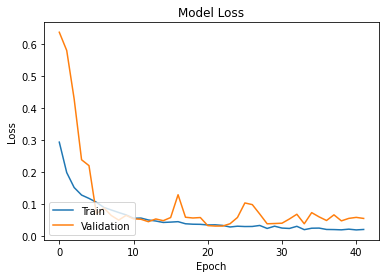

In [0]:
plt.plot(history_aug_3.history['accuracy'])
plt.plot(history_aug_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_aug_3.history['loss'])
plt.plot(history_aug_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_aug_5, validation_acc_aug_5 = model_data_aug_3.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_aug_5)

6/6 [==============================] - 0s 5ms/step - loss: 0.0524 - accuracy: 0.9503
validation_acc: 0.950276255607605


In [0]:
validation_loss_aug5, validation_acc_aug5 = model_data_aug_3.evaluate_generator(validation_genrator_3, steps=10)
print(validation_acc_aug5)

0.950276255607605


In [0]:
test_loss_aug_3, test_acc_aug_3 = model_data_aug_3.evaluate_generator(test_generator_3, steps=30)
print(test_acc_aug_3)

0.9005848169326782


In [0]:
test_loss_aug_r2, test_acc_aug_r2 = model_data_aug_3.evaluate(test_img, y_test, verbose=1)
print(test_acc_aug_r2)

6/6 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.9006
0.9005848169326782


In [0]:
train_datagen_4 = ImageDataGenerator(rotation_range=50,
                               width_shift_range=0.5,
                               height_shift_range=0.5,
                               shear_range=0.5,
                               zoom_range=0.5,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_4 = ImageDataGenerator(rescale=1./255)
test_datagen_4 = ImageDataGenerator(rescale=1./255)

train_generator_4 = train_datagen.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 50,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_4 = validation_datagen.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_4 = test_datagen.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_data_aug_4 = Sequential()
model_data_aug_4.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug_4.add(BatchNormalization())
model_data_aug_4.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_4.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_4.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug_4.add(MaxPool2D(pool_size=(2,2)))
model_data_aug_4.add(Dropout(0.25))
model_data_aug_4.add( Flatten() )
model_data_aug_4.add( Dense(128, activation = 'relu' ) )
model_data_aug_4.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0

In [0]:
model_data_aug_4.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_o = ModelCheckpoint(filepath = 'my_best_model.hdf10', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_p = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_aug_4 = model_data_aug_4.fit_generator(train_generator_4, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_o, callback_p],
                                       validation_data=validation_genrator_4,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.5856
Epoch 00001: val_loss improved from inf to 0.48685, saving model to my_best_model.hdf10
100/100 [==============================] - 16s 158ms/step - loss: 0.3166 - accuracy: 0.5856 - val_loss: 0.4868 - val_accuracy: 0.3149
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.7541
Epoch 00002: val_loss improved from 0.48685 to 0.42342, saving model to my_best_model.hdf10
100/100 [==============================] - 16s 163ms/step - loss: 0.2048 - accuracy: 0.7541 - val_loss: 0.4234 - val_accuracy: 0.3757
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.7853
Epoch 00003: val_loss improved from 0.42342 to 0.33413, saving model to my_best_model.hdf10
100/100 [==============================] - 15s 153ms/step - loss: 0.1782 - accuracy: 0.7853 - val_loss: 0.3341 - val_accuracy: 0.4917
Epoch 4/100
100/100 [==============

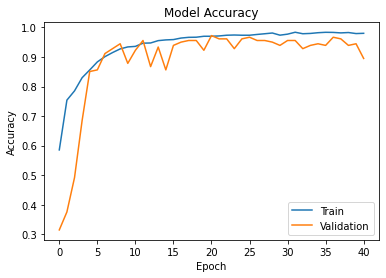

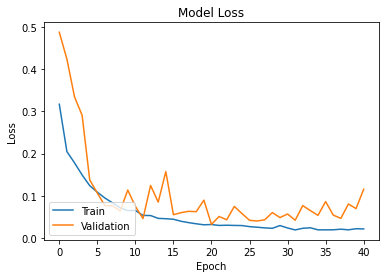

In [0]:
plt.plot(history_aug_4.history['accuracy'])
plt.plot(history_aug_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_aug_4.history['loss'])
plt.plot(history_aug_4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_aug_6, validation_acc_aug_6 = model_data_aug_4.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_aug_6)

6/6 [==============================] - 0s 5ms/step - loss: 0.1155 - accuracy: 0.8950
validation_acc: 0.8950276374816895


In [0]:
validation_loss_aug6, validation_acc_aug6 = model_data_aug_4.evaluate_generator(validation_genrator_4, steps=10)
print(validation_acc_aug6)

0.8950276374816895


In [0]:
test_loss_aug_4, test_acc_aug_4 = model_data_aug_4.evaluate_generator(test_generator_4, steps=30)
print(test_acc_aug_4)

0.8070175647735596


In [0]:
test_loss_aug_r3, test_acc_aug_r3 = model_data_aug_4.evaluate(test_img, y_test, verbose=1)
print(test_acc_aug_r3)

6/6 [==============================] - 0s 5ms/step - loss: 0.2658 - accuracy: 0.8070
0.8070175647735596


#**Phase 5. Effect of Regularization**


**The best model architecture was obtained in phase 2, which is**


```
# K.clear_session()
model_data_aug = Sequential()
model_data_aug.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_data_aug.add(BatchNormalization())
model_data_aug.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug.add(MaxPool2D(pool_size=(2,2)))
model_data_aug.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_data_aug.add(MaxPool2D(pool_size=(2,2)))
model_data_aug.add(Dropout(0.25))
model_data_aug.add( Flatten() )
model_data_aug.add( Dense(128, activation = 'relu' ) )
model_data_aug.add( Dense(6, activation = 'sigmoid' ) )
model_data_aug.summary()
```
**Based on the best model, here is what the plan is because with my best model already has regularization layers**

1.   Instead of using BatchNormalization(), going to use L2/Dropout in the first layer.
2.   Instead of using Dropout, going to use L2/BatchNormalization
3.   Combiation of it, such as BatchNorm()/BatchNorm, L2/L2, Dropout/Dropout




##**Use L2 or Dropout Layers instead of BatchNorm()**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_reg = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               rescale=1./255,
                               fill_mode='nearest')

validation_datagen_reg = ImageDataGenerator(rescale=1./255)
test_datagen_reg = ImageDataGenerator(rescale=1./255)

train_generator_reg = train_datagen_reg.flow_from_directory(Train_dir,
                                                    target_size = (140, 90),
                                                    color_mode='grayscale',
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    shuffle=True
                                                    )

validation_genrator_reg = validation_datagen_reg.flow_from_directory(Valid_dir, 
                                                   target_size=(140, 90),
                                                   color_mode='grayscale',
                                                   batch_size = 181,
                                                   class_mode='categorical',
                                                   shuffle=True)
 
test_generator_reg = test_datagen_reg.flow_from_directory(Test_dir, 
                                                  target_size = (140, 90),
                                                  color_mode='grayscale',
                                                  batch_size = 171 ,
                                                  class_mode='categorical')

Found 788 images belonging to 6 classes.
Found 181 images belonging to 6 classes.
Found 171 images belonging to 6 classes.


In [0]:
K.clear_session()
model_reg = Sequential()
model_reg.add( Conv2D(32, (3, 3), activation= 'relu', activity_regularizer=l2(0.01), input_shape = train_img[0, :, :, :].shape))
model_reg.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg.add(MaxPool2D(pool_size=(2,2)))
model_reg.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg.add(MaxPool2D(pool_size=(2,2)))
model_reg.add(Dropout(0.25))
model_reg.add( Flatten() )
model_reg.add( Dense(128, activation = 'relu' ) )
model_reg.add( Dense(6, activation = 'sigmoid' ) )
model_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 20, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21120)             0

In [0]:
model_reg.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_reg_mc = ModelCheckpoint(filepath = 'my_best_reg.hdf1', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_reg_es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_reg = model_reg.fit_generator(train_generator_reg, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_reg_mc, callback_reg_es],
                                       validation_data=validation_genrator_reg,
                                       validation_steps =valid_images.shape[0] / 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.3411
Epoch 00001: val_loss improved from inf to 0.38168, saving model to my_best_reg.hdf1
100/100 [==============================] - 14s 136ms/step - loss: 0.9851 - accuracy: 0.3411 - val_loss: 0.3817 - val_accuracy: 0.5083
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3676 - accuracy: 0.4995
Epoch 00002: val_loss improved from 0.38168 to 0.25779, saving model to my_best_reg.hdf1
100/100 [==============================] - 14s 137ms/step - loss: 0.3670 - accuracy: 0.5000 - val_loss: 0.2578 - val_accuracy: 0.7901
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.6022
Epoch 00003: val_loss improved from 0.25779 to 0.23800, saving model to my_best_reg.hdf1
100/100 [==============================] - 13s 128ms/step - loss: 0.3061 - accuracy: 0.6022 - val_loss

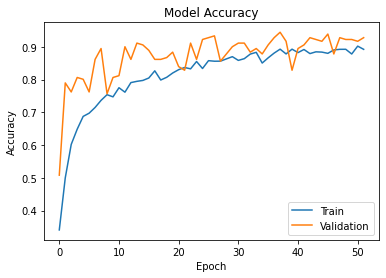

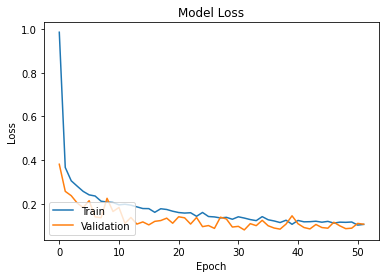

In [0]:
plt.plot(history_reg.history['accuracy'])
plt.plot(history_reg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_reg, validation_acc_reg = model_reg.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_reg)

validation_loss_reg2, validation_acc_reg2 = model_reg.evaluate_generator(validation_genrator_reg, steps=10)
print('validatiation_acc on generated data', validation_acc_reg)

6/6 [==============================] - 0s 40ms/step - loss: 0.1050 - accuracy: 0.9282
validation_acc: 0.9281768202781677
Instructions for updating:
Please use Model.evaluate, which supports generators.
validatiation_acc on generated data 0.9281768202781677


In [0]:
test_loss_reg, test_acc_reg = model_reg.evaluate_generator(test_generator_reg, steps=30)
print('test_acc:', test_acc_reg)

test_acc: 0.8011695742607117


In [0]:
predictions_reg = model_reg.predict( valid_img )
predictions_reg = np.argmax(predictions_reg, axis=1)

test_loss_reg_r, test_acc_reg_r = model_reg.evaluate(test_img, y_test, verbose=1)
print(test_acc_reg_r)

6/6 [==============================] - 0s 29ms/step - loss: 0.1951 - accuracy: 0.8012
0.8011695742607117


##**Use Dropout Layers instead of BatchNorm()**

In [0]:
K.clear_session()
model_reg1 = Sequential()
model_reg1.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_reg1.add(Dropout(0.25))
model_reg1.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg1.add(MaxPool2D(pool_size=(2,2)))
model_reg1.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg1.add(MaxPool2D(pool_size=(2,2)))
model_reg1.add(Dropout(0.25))
model_reg1.add( Flatten() )
model_reg1.add( Dense(128, activation = 'relu' ) )
model_reg1.add( Dense(6, activation = 'sigmoid' ) )
model_reg1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
dropout (Dropout)            (None, 138, 88, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 20, 32)        0

In [0]:
model_reg1.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_reg_mc1 = ModelCheckpoint(filepath = 'my_best_reg.hdf2', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_reg_es1 = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_reg_1= model_reg1.fit_generator(train_generator_reg, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_reg_mc1, callback_reg_es1],
                                       validation_data=validation_genrator_reg,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.4593
Epoch 00001: val_loss improved from inf to 0.25975, saving model to my_best_reg.hdf2
100/100 [==============================] - 13s 127ms/step - loss: 0.3691 - accuracy: 0.4593 - val_loss: 0.2597 - val_accuracy: 0.7403
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.6199
Epoch 00002: val_loss improved from 0.25975 to 0.19145, saving model to my_best_reg.hdf2
100/100 [==============================] - 13s 127ms/step - loss: 0.2803 - accuracy: 0.6199 - val_loss: 0.1914 - val_accuracy: 0.8232
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.6808
Epoch 00003: val_loss improved from 0.19145 to 0.17512, saving model to my_best_reg.hdf2
100/100 [==============================] - 13s 127ms/step - loss: 0.2460 - accuracy: 0.6808 - val_loss: 0.1751 - val_accuracy: 0.7680
Epoch 4/100
100/100 [=======================

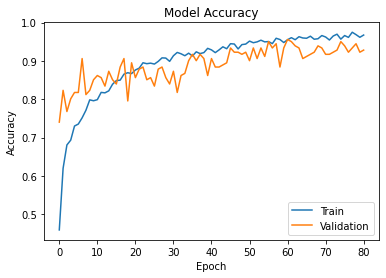

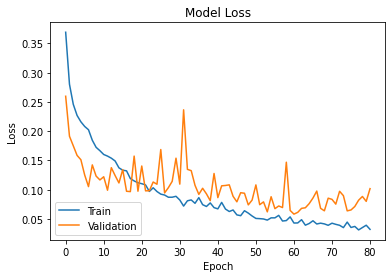

In [0]:
plt.plot(history_reg_1.history['accuracy'])
plt.plot(history_reg_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_reg_1.history['loss'])
plt.plot(history_reg_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_reg_r, validation_acc_reg_r = model_reg1.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_reg_r)

validation_loss_reg1, validation_acc_reg1 = model_reg1.evaluate_generator(validation_genrator_reg, steps=10)
print('validatiation_acc on generated data', validation_acc_reg1)

6/6 [==============================] - 0s 15ms/step - loss: 0.0963 - accuracy: 0.9282
validation_acc: 0.9281768202781677
validatiation_acc on generated data 0.9281768202781677


In [0]:
test_loss_reg1, test_acc_reg1 = model_reg1.evaluate_generator(test_generator_reg, steps=20)
print('test_acc:', test_acc_reg1)

test_loss_reg_r1, test_acc_reg_r1 = model_reg1.evaluate(test_img, y_test, verbose=1)
print(test_acc_reg_r1)

test_acc: 0.8421052694320679
6/6 [==============================] - 0s 14ms/step - loss: 0.1757 - accuracy: 0.8421
0.8421052694320679


##**Use the L2 After Third Convolutional Layers**

In [0]:
K.clear_session()
model_reg2 = Sequential()
model_reg2.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_reg2.add(BatchNormalization())
model_reg2.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg2.add(MaxPool2D(pool_size=(2,2)))
model_reg2.add( Conv2D(32, ( 3, 3 ), activation = 'relu' , activity_regularizer=l2(0.01)) )
model_reg2.add(MaxPool2D(pool_size=(2,2)))
model_reg2.add( Flatten() )
model_reg2.add( Dense(128, activation = 'relu' ) )
model_reg2.add( Dense(6, activation = 'sigmoid' ) )
model_reg2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21120)             0

In [0]:
model_reg2.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_reg_mc2 = ModelCheckpoint(filepath = 'my_best_reg.hdf3', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_reg_es2 = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_reg_2= model_reg2.fit_generator(train_generator_reg, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_reg_mc2, callback_reg_es2],
                                       validation_data=validation_genrator_reg,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.2156 - accuracy: 0.2895
Epoch 00001: val_loss improved from inf to 0.49209, saving model to my_best_reg.hdf3
100/100 [==============================] - 13s 125ms/step - loss: 1.2156 - accuracy: 0.2895 - val_loss: 0.4921 - val_accuracy: 0.1657
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.5229
Epoch 00002: val_loss did not improve from 0.49209
100/100 [==============================] - 12s 123ms/step - loss: 0.4005 - accuracy: 0.5229 - val_loss: 0.5771 - val_accuracy: 0.1934
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.5602
Epoch 00003: val_loss improved from 0.49209 to 0.40796, saving model to my_best_reg.hdf3
100/100 [==============================] - 13s 126ms/step - loss: 0.3771 - accuracy: 0.5602 - val_loss: 0.4080 - val_accuracy: 0.3867
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.3351 - ac

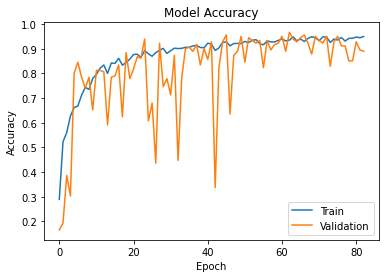

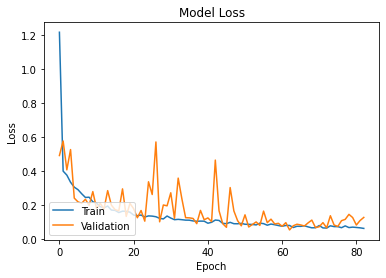

In [0]:
plt.plot(history_reg_2.history['accuracy'])
plt.plot(history_reg_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_reg_2.history['loss'])
plt.plot(history_reg_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_reg_r2, validation_acc_reg_r2 = model_reg2.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_reg_r2)

validation_loss_reg2, validation_acc_reg2 = model_reg2.evaluate_generator(validation_genrator_reg, steps=10)
print('validatiation_acc on generated data', validation_acc_reg2)

6/6 [==============================] - 0s 16ms/step - loss: 0.1302 - accuracy: 0.8895
validation_acc: 0.889502763748169
validatiation_acc on generated data 0.889502763748169


In [0]:
test_loss_reg2, test_acc_reg2 = model_reg2.evaluate_generator(test_generator_reg, steps=20)
print('test_acc:', test_acc_reg2)

test_loss_reg_r2, test_acc_reg_r2 = model_reg2.evaluate(test_img, y_test, verbose=1)
print(test_acc_reg_r2)

test_acc: 0.8888888955116272
6/6 [==============================] - 0s 15ms/step - loss: 0.1177 - accuracy: 0.8889
0.8888888955116272


##**Use the BatchNorm After Third Confolvutional Layers**


In [0]:
K.clear_session()
model_reg3 = Sequential()
model_reg3.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = train_img[0, :, :, :].shape))
model_reg3.add(BatchNormalization())
model_reg3.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg3.add(MaxPool2D(pool_size=(2,2)))
model_reg3.add( Conv2D(32, ( 3, 3 ), activation = 'relu' ) )
model_reg3.add(MaxPool2D(pool_size=(2,2)))
model_reg3.add(BatchNormalization())
model_reg3.add( Flatten() )
model_reg3.add( Dense(128, activation = 'relu' ) )
model_reg3.add( Dense(6, activation = 'sigmoid' ) )
model_reg3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 88, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 88, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 86, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 20, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 20, 32)        1

In [0]:
model_reg3.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
callback_reg_mc3 = ModelCheckpoint(filepath = 'my_best_reg.hdf4', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_reg_es3 = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [0]:
history_reg_3= model_reg3.fit_generator(train_generator_reg, 
                                       steps_per_epoch=100,
                                       epochs=100,
                                       callbacks=[callback_reg_mc3, callback_reg_es3],
                                       validation_data=validation_genrator_reg,
                                       validation_steps =valid_images.shape[0] / 10)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.6023
Epoch 00001: val_loss improved from inf to 0.70396, saving model to my_best_reg.hdf4
100/100 [==============================] - 13s 134ms/step - loss: 0.5010 - accuracy: 0.6023 - val_loss: 0.7040 - val_accuracy: 0.1989
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.7419
Epoch 00002: val_loss improved from 0.70396 to 0.60227, saving model to my_best_reg.hdf4
100/100 [==============================] - 14s 137ms/step - loss: 0.2411 - accuracy: 0.7419 - val_loss: 0.6023 - val_accuracy: 0.1934
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.7734
Epoch 00003: val_loss did not improve from 0.60227
100/100 [==============================] - 12s 122ms/step - loss: 0.1980 - accuracy: 0.7734 - val_loss: 0.7125 - val_accuracy: 0.3204
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.1858 - ac

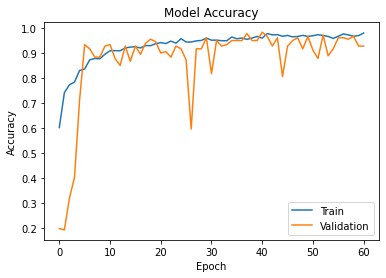

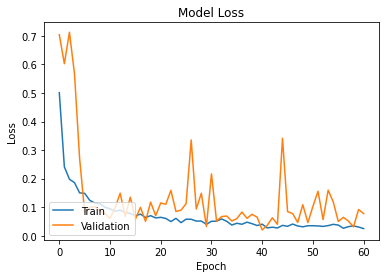

In [0]:
plt.plot(history_reg_3.history['accuracy'])
plt.plot(history_reg_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history_reg_3.history['loss'])
plt.plot(history_reg_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

In [0]:
validation_loss_reg_r3, validation_acc_reg_r3 = model_reg3.evaluate( valid_img, y_valid )
print( 'validation_acc:', validation_acc_reg_r3)

validation_loss_reg3, validation_acc_reg3 = model_reg3.evaluate_generator(validation_genrator_reg, steps=10)
print('validatiation_acc on generated data', validation_acc_reg3)

6/6 [==============================] - 0s 34ms/step - loss: 0.0751 - accuracy: 0.9282
validation_acc: 0.9281768202781677
validatiation_acc on generated data 0.9281768202781677


In [0]:
test_loss_reg3, test_acc_reg3 = model_reg3.evaluate_generator(test_generator_reg, steps=20)
print('test_acc:', test_acc_reg3)

test_loss_reg_r3, test_acc_reg_r3 = model_reg2.evaluate(test_img, y_test, verbose=1)
print(test_acc_reg_r3)

test_acc: 0.9298245906829834
6/6 [==============================] - 0s 12ms/step - loss: 0.1177 - accuracy: 0.8889
0.8888888955116272


##**Conclusion**